In [8]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform, filters
import sys, pylab, operator, csv
#import util
import os
import urllib

%matplotlib notebook

%load_ext autoreload
%autoreload 2

import caffe

# COCO API
coco_root = '/data/datasets/coco'  # modify to point to your COCO installation
sys.path.insert(0, coco_root + '/PythonAPI')
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask

# CAFFE
caffe_root = '/users/ruthfong/sample_code/Caffe-ExcitationBP'

from helpers import *
from heatmaps import *
#from repro_EB_figs import *
from optimize_mask import optimize_mask, generate_learned_mask

import coco_util

tags, tag2ID = coco_util.loadTags(caffe_root + '/models/COCO/catName.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
dataset = 'coco'
data_desc = 'val'
gpu = 1
net_type = 'googlenet'
start = 0
end = 500
fig_dir = None
mask_dir = None
show_fig = True

if gpu is not None:
    caffe.set_device(gpu)
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()

In [3]:
assert(net_type == 'googlenet')
assert(data_desc == 'val')

# load COCO val2014
imset   = 'val2014'
imgDir  = '%s/images/%s/'%(coco_root, imset)
annFile = '%s/annotations/instances_%s.json'%(coco_root, imset)
cocoAnn = COCO(annFile)
cocoAnn.info()
catIds  = cocoAnn.getCatIds()
catList = cocoAnn.loadCats(catIds)

loading annotations into memory...
Done (t=6.28s)
creating index...
index created!
description: This is stable 1.0 version of the 2014 MS COCO dataset.
url: http://mscoco.org
version: 1.0
year: 2014
contributor: Microsoft COCO group
date_created: 2015-01-27 09:11:52.357475


In [27]:
(path.strip('.jpg').split('/')[-1], label)

(u'COCO_val2014_000000229383', 0)

In [48]:
end = 400
paths = []
labels = []
for cat in catList:
    catLabel = tag2ID[cat['name']]
    imgIds  = cocoAnn.getImgIds(catIds=cat['id'])
    imgList = cocoAnn.loadImgs(ids=imgIds)
    if end is not None:
        catPaths = [os.path.join(imgDir, I['file_name']) for I in imgList[:np.minimum(end, len(imgList))]]
    else:
        catPaths = [os.path.join(imgDir, I['file_name']) for I in imgList]
    catLabels = np.ones(len(catPaths)).astype(int) * catLabel
    paths.extend(catPaths)
    labels.extend(catLabels)
paths = np.array(paths)
labels = np.array(labels)
target_range = range(0, len(paths))

labels_desc = tags

print len(paths), len(np.unique(paths))
print labels_desc

30989 20721
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
python optimize_mask.py -n googlenet -g 0 -c 500 -s 0 -e 2500 -f /data/ruthfong/neural_coding/pycaffe_figs/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_l1_lambda2_-inf_tv_lambda_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 -m /data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 coco val

In [50]:
for i in range(0,32):
    print 'python optimize_mask.py -n googlenet -g %d -c 400 -s %d -e %d -m /data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 coco val' % (((i%16)/4), i*940, (i+1)*940)

python optimize_mask.py -n googlenet -g 0 -c 400 -s 0 -e 940 -m /data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 coco val
python optimize_mask.py -n googlenet -g 0 -c 400 -s 940 -e 1880 -m /data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 coco val
python optimize_mask.py -n googlenet -g 0 -c 400 -s 1880 -e 2820 -m /data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 coco val
python optimize_mask.py -n googlenet -g 0 -c 400 -s 2820 -e 3760 -m /dat

In [36]:
#mask = np.load('/data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2/COCO_val2014_000000328430_0.npy')
mask = caffe.io.load_image('/data/ruthfong/neural_coding/pycaffe_figs/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2/COCO_val2014_000000328430_0.png')
mask = caffe.io.load_image('/data/ruthfong/neural_coding/pycaffe_figs/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_l1_lambda2_-inf_tv_lambda_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2/COCO_val2014_000000328430_0.png')
f, ax = plt.subplots(1,1)
ax.imshow(mask)
plt.show()

IOError: [Errno 2] No such file or directory: '/data/ruthfong/neural_coding/pycaffe_figs/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2/COCO_val2014_000000328430_0.png'

In [5]:
net = get_net('googlenet_coco')
net_transformer = get_COCO_net_transformer(net)

In [ ]:
for 
'python optimize_mask.py -n googlenet -g 0 -c 500 -s 2500 -e 5000 -f /data/ruthfong/neural_coding/pycaffe_figs/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_l1_lambda2_-inf_tv_lambda_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 -m /data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2 coco val'

In [29]:
# localization parameters
num_iters = 300
lr = 1e-1
l1_lambda = 1e-3
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 2
jitter = 4
num_top = 5
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

#mask_init = None
plot_step = 50
debug = False
verbose = False
mask_init_type = 'circle'

fig_dir = os.path.join('/data/ruthfong/neural_coding/pycaffe_figs/%s_%s_%s_given_grad_%d_norm_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_l1_lambda2_%.2f_tv_lambda_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2' % (
        net_type, dataset, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters))
mask_dir = os.path.join('/data/ruthfong/neural_coding/pycaffe_results/%s_%s_%s_given_grad_%d_norm_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_tv_lambda_%.2f_l1_lambda_2_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2' % (
        net_type, dataset, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters))    

print fig_dir
print mask_dir

/data/ruthfong/neural_coding/pycaffe_figs/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_l1_lambda2_-inf_tv_lambda_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2
/data/ruthfong/neural_coding/pycaffe_results/googlenet_coco_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2


/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10
/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log10
/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in log10


/data/ruthfong/neural_coding/pycaffe_results/googlenet_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2/0.npy already exists; cancel if you don't want to overwrite it


<IPython.core.display.Javascript object>


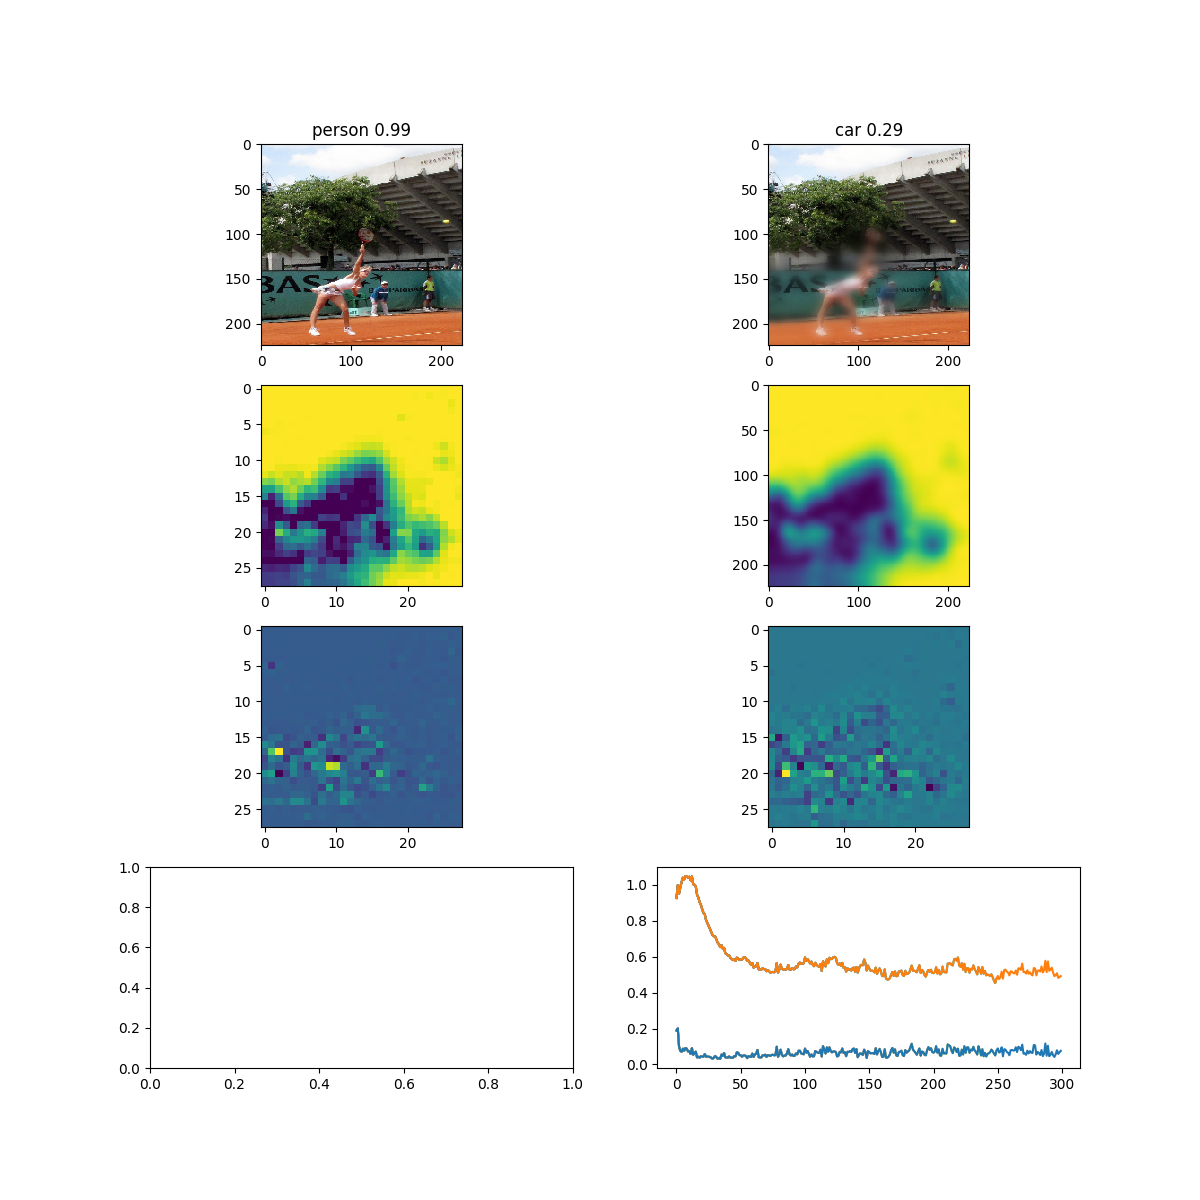

/data/ruthfong/neural_coding/pycaffe_results/googlenet_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2/1.npy already exists; cancel if you don't want to overwrite it


<IPython.core.display.Javascript object>


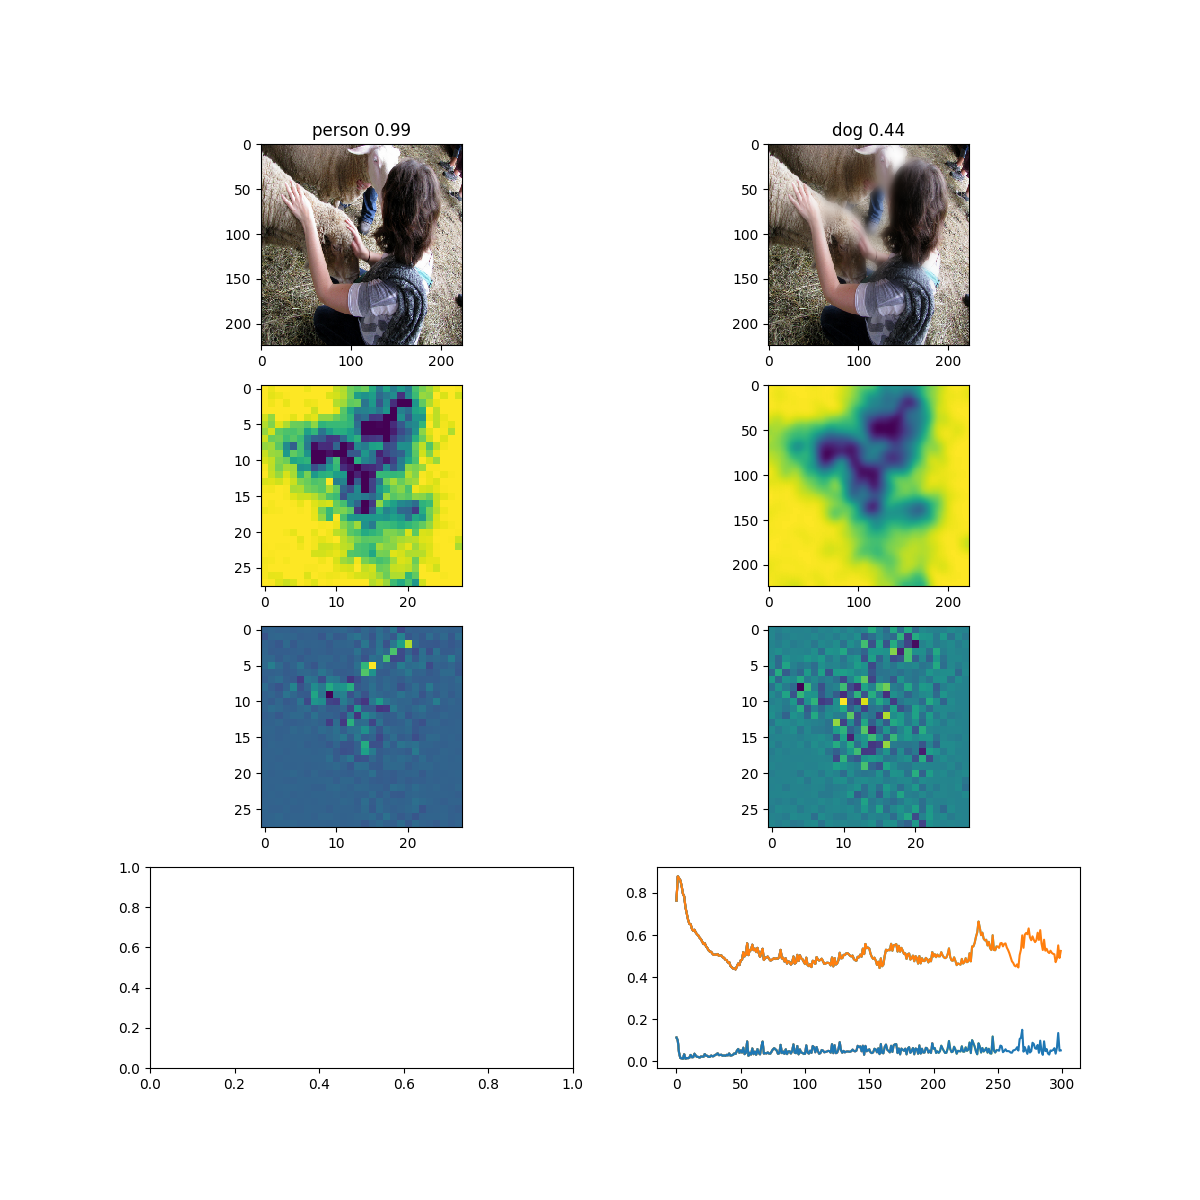

<IPython.core.display.Javascript object>


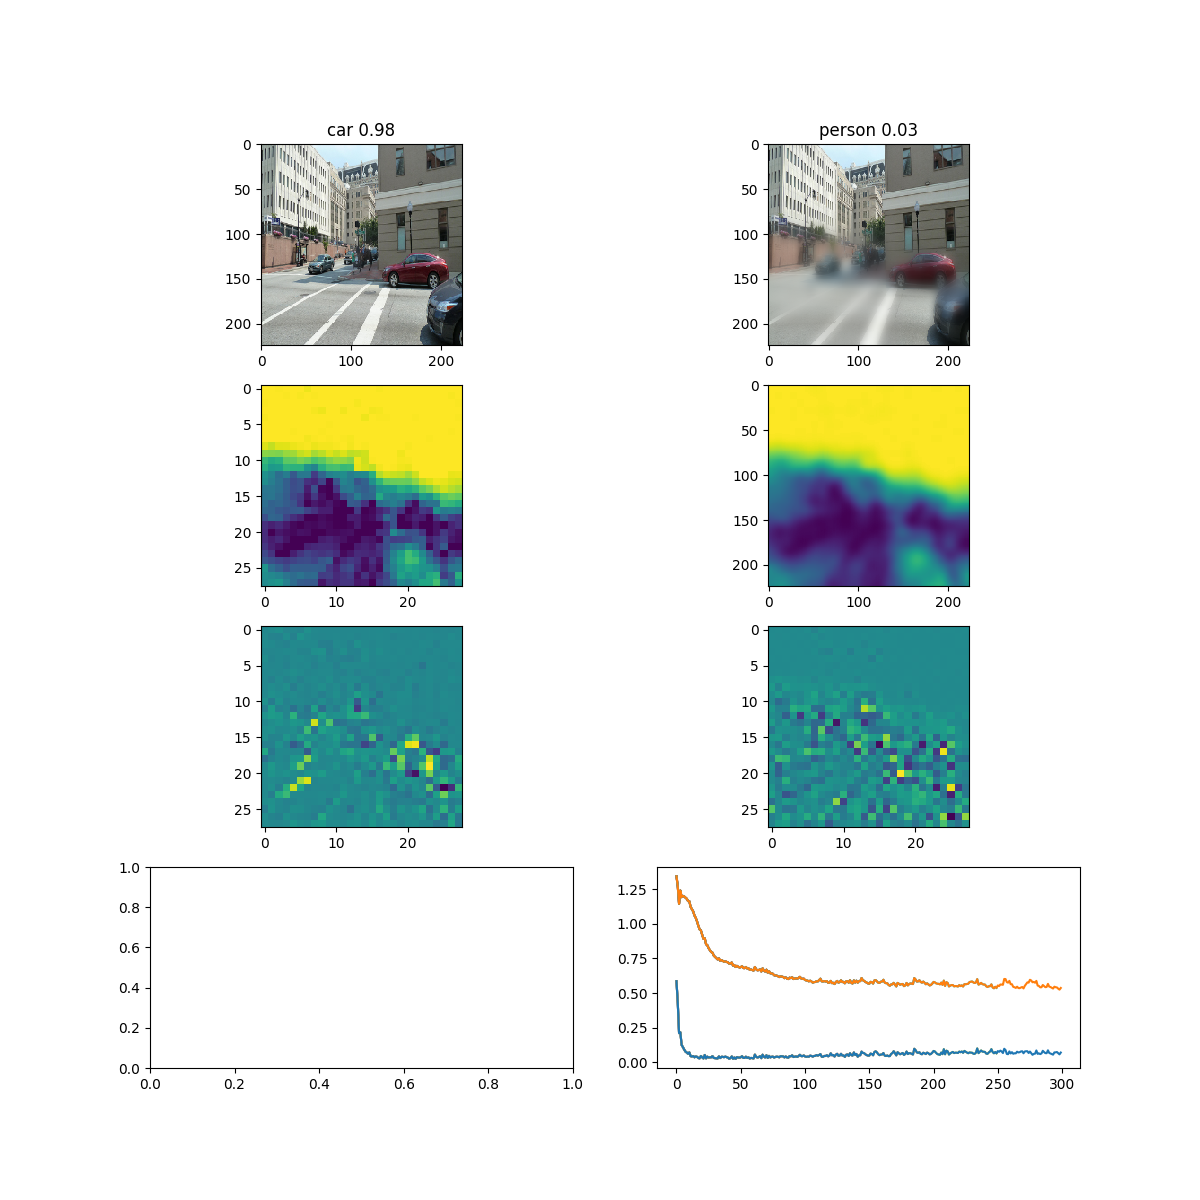

<IPython.core.display.Javascript object>


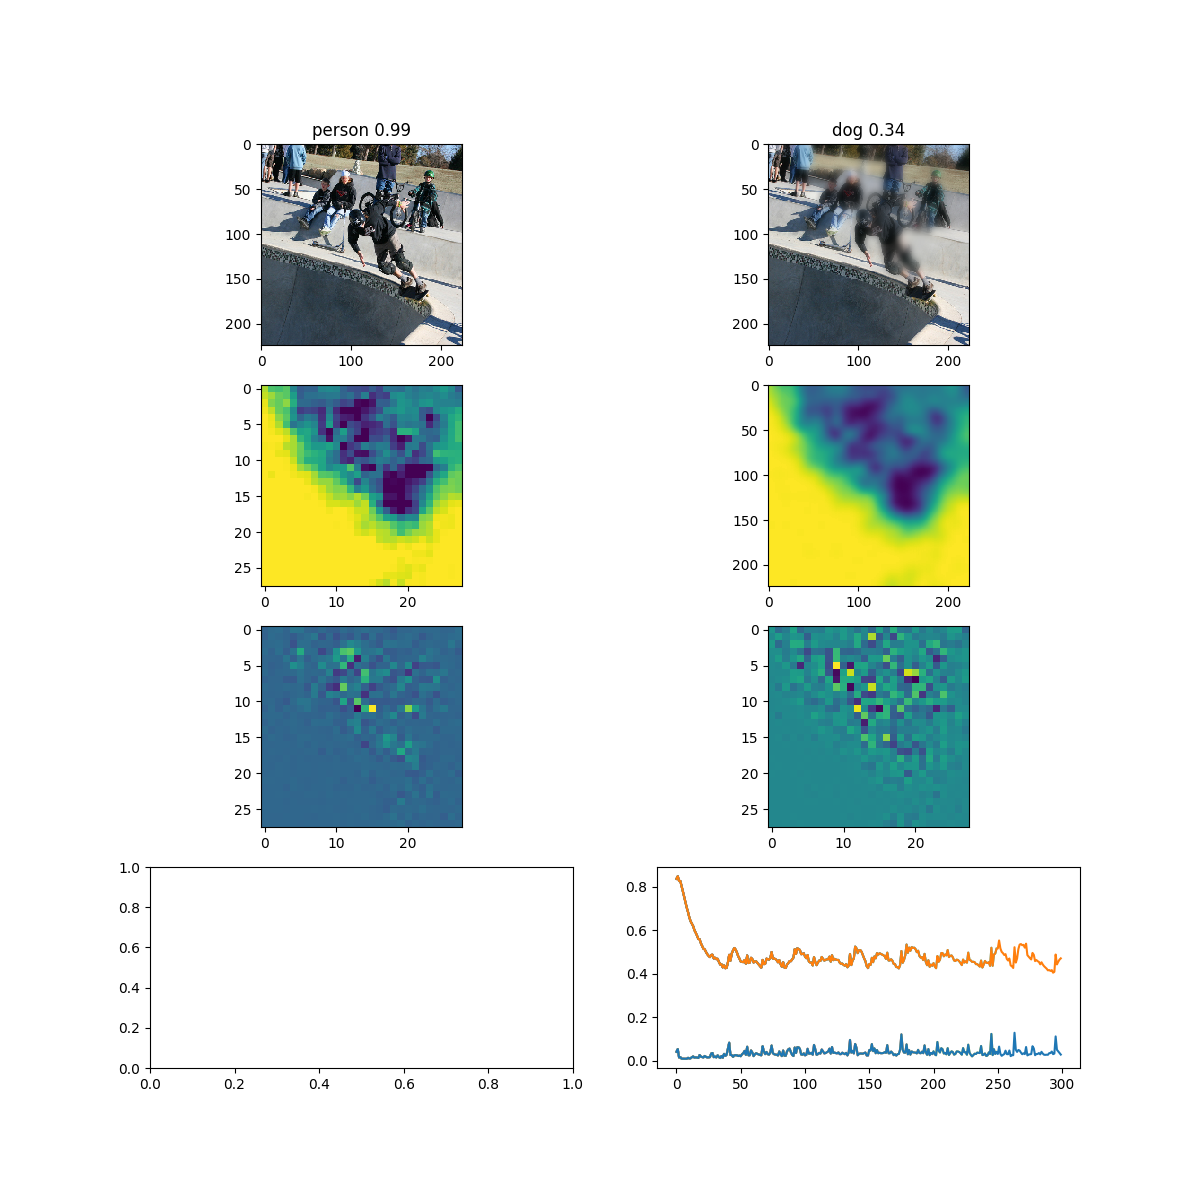

<IPython.core.display.Javascript object>


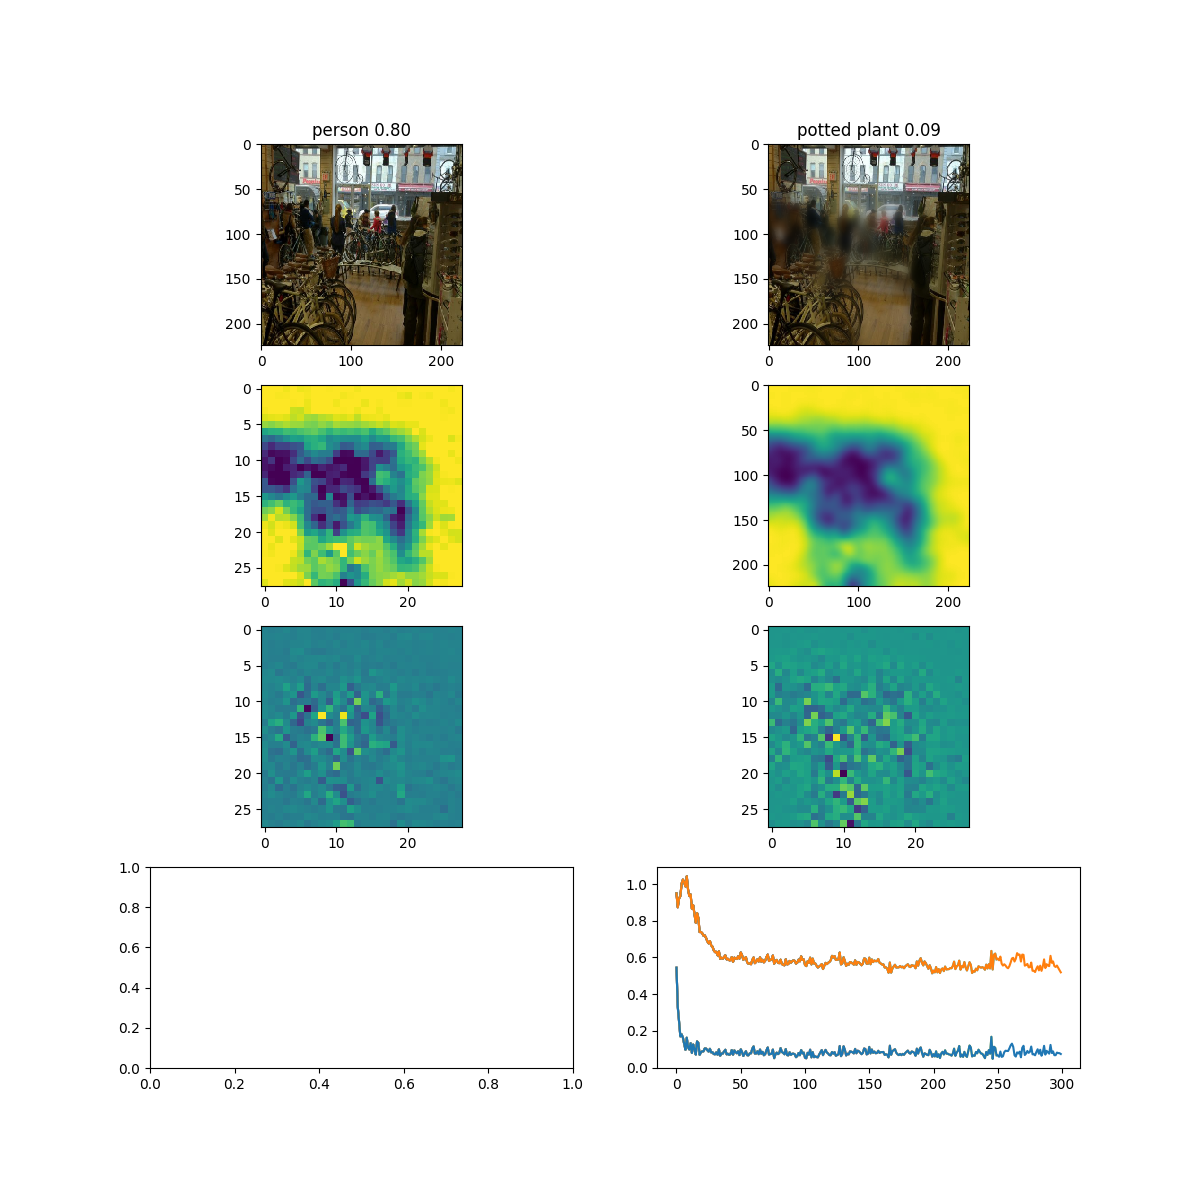

<IPython.core.display.Javascript object>


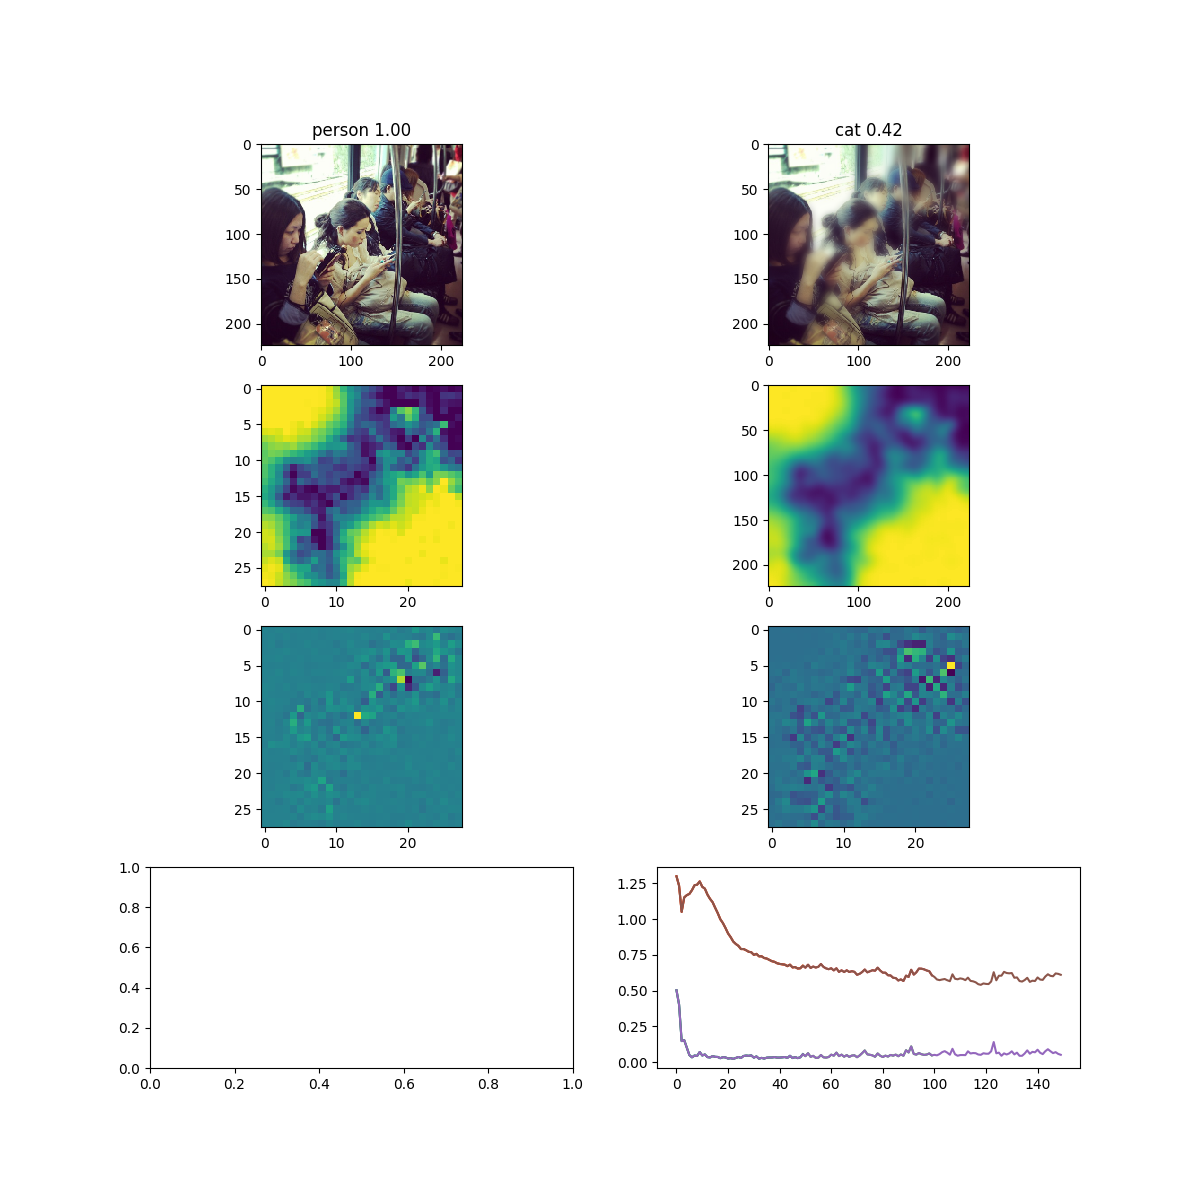

KeyboardInterrupt: 

In [16]:
# localization parameters
num_iters = 300
lr = 1e-1
l1_lambda = 1e-3
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 2
jitter = 4
num_top = 5
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

#mask_init = None
plot_step = 50
debug = False
verbose = False
mask_init_type = 'circle'

fig_dir = os.path.join('/data/ruthfong/neural_coding/pycaffe_figs/%s_%s_%s_given_grad_%d_norm_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_l1_lambda2_%.2f_tv_lambda_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2' % (
        net_type, dataset, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters))
mask_dir = os.path.join('/data/ruthfong/neural_coding/pycaffe_results/%s_%s_%s_given_grad_%d_norm_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_tv_lambda_%.2f_l1_lambda_2_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2' % (
        net_type, dataset, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters))    

for i in range(10):
    #net = get_net(net_type)
    net.blobs['data'].data.reshape(1,3,224,224)

    path = paths[i]
    label = labels[i]
    img = net_transformer.preprocess('data', caffe.io.load_image(path))
    net.blobs['data'].data[...] = img
    net.forward()
    scores = np.squeeze(net.blobs['prob'].data)
    sorted_idx = np.argsort(scores)
    if given_gradient:
        target = np.zeros(scores.shape)
        target[sorted_idx[:-(num_top+1):-1]] = 1
    else:
        target = sorted_idx[:-(num_top+1):-1]

    fig_path = None
    mask_path = None
    
    fig_path = os.path.join(fig_dir, '%d_%d.png' % (int(path.strip('.jpg').split('_')[-1]), label))
    mask_path = os.path.join(mask_dir, '%d_%d.npy' % (int(path.strip('.jpg').split('_')[-1]), label))

    #mask = optimize_mask(net, path, target, labels = labels_desc, given_gradient = given_gradient, norm_score = norm_score,
    #                num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, l1_ideal = l1_ideal,
    #                l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, mask_scale = mask_scale,
    #                use_conv_norm= use_conv_norm, blur_mask = blur_mask, jitter = jitter,
    #                null_type = null_type, mask_init = mask_init, gpu = gpu, start_layer = None, end_layer = end_layer,
    #                plot_step = plot_step, debug = debug, fig_path = fig_path, mask_path = mask_path, verbose = verbose)
    generate_learned_mask(net, net_transformer, path, label, given_gradient = given_gradient, 
                          norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                          l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                          mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                          jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                          start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                          fig_path = fig_path, mask_path = mask_path, verbose = verbose, show_fig = show_fig, 
                          mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)


/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/users/ruthfong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


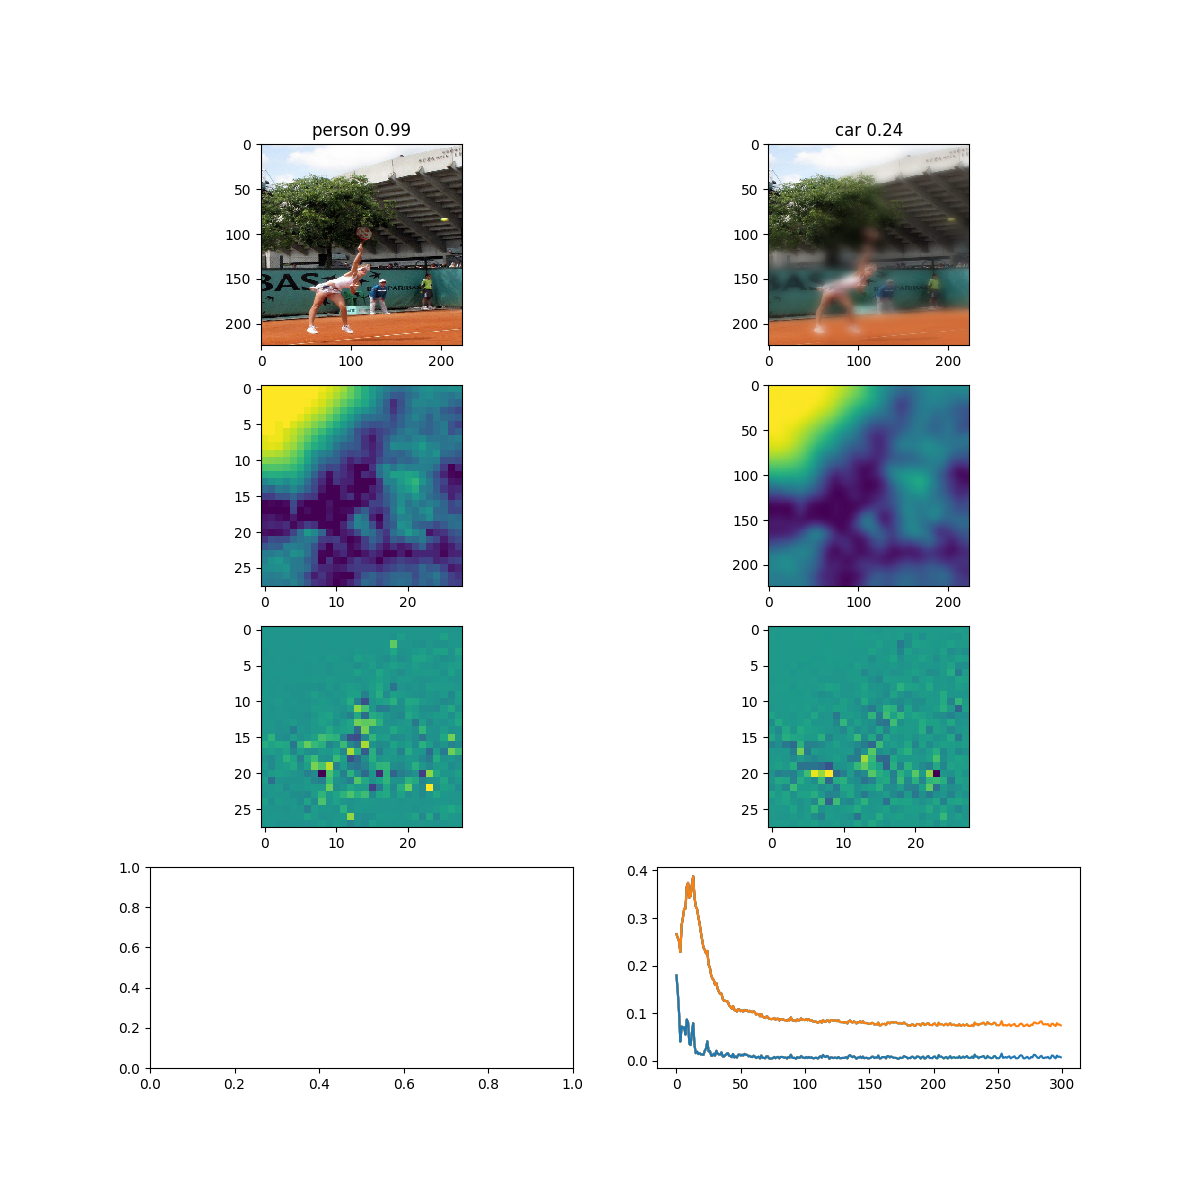

<IPython.core.display.Javascript object>


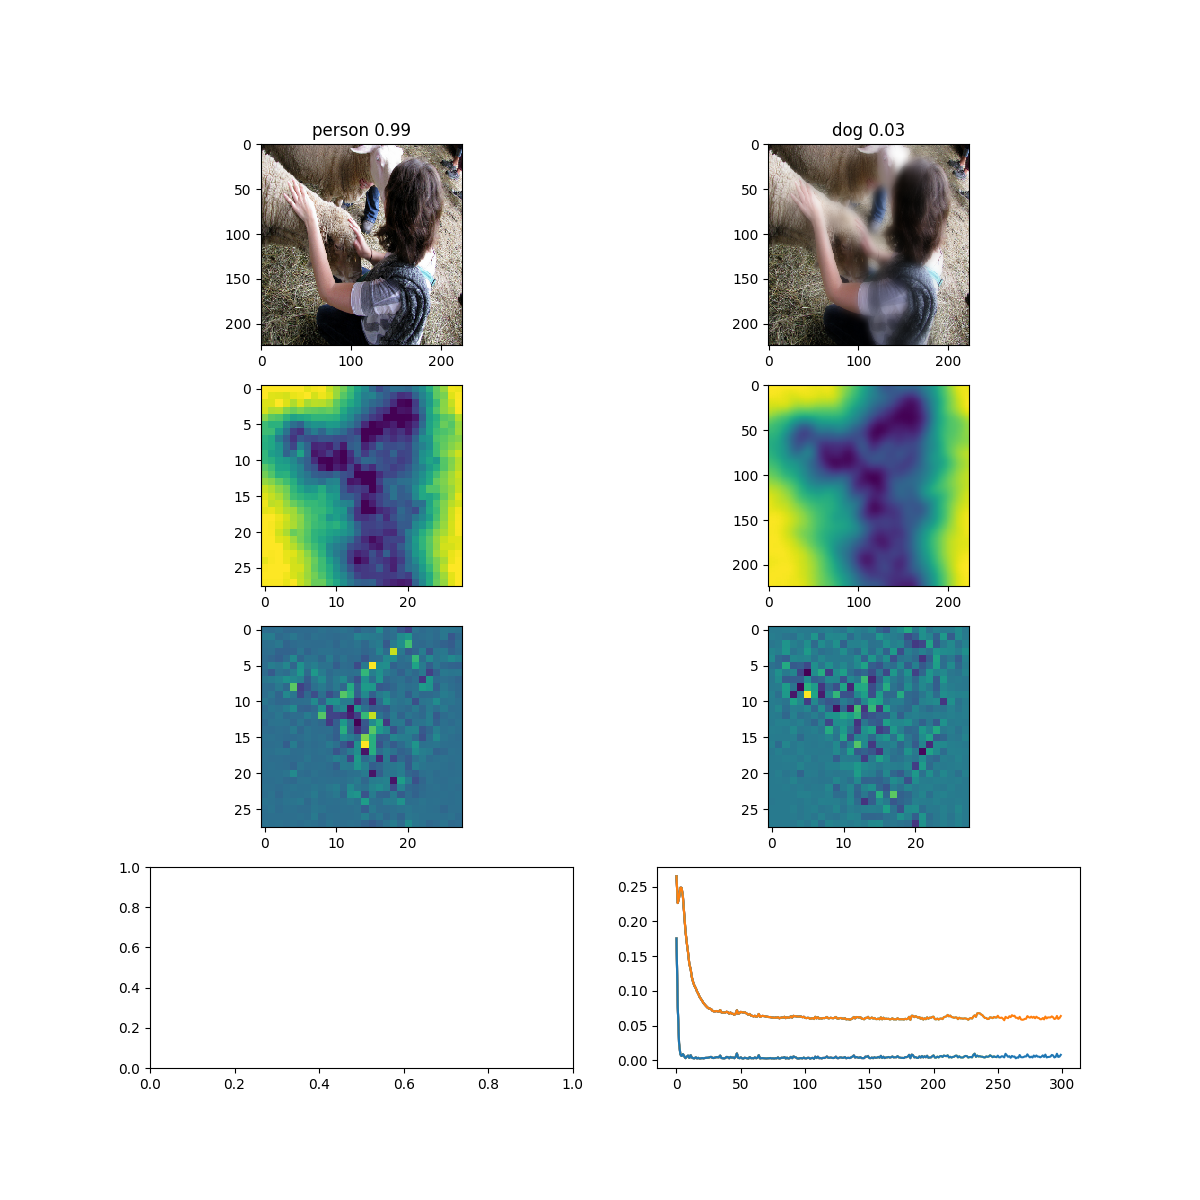

<IPython.core.display.Javascript object>


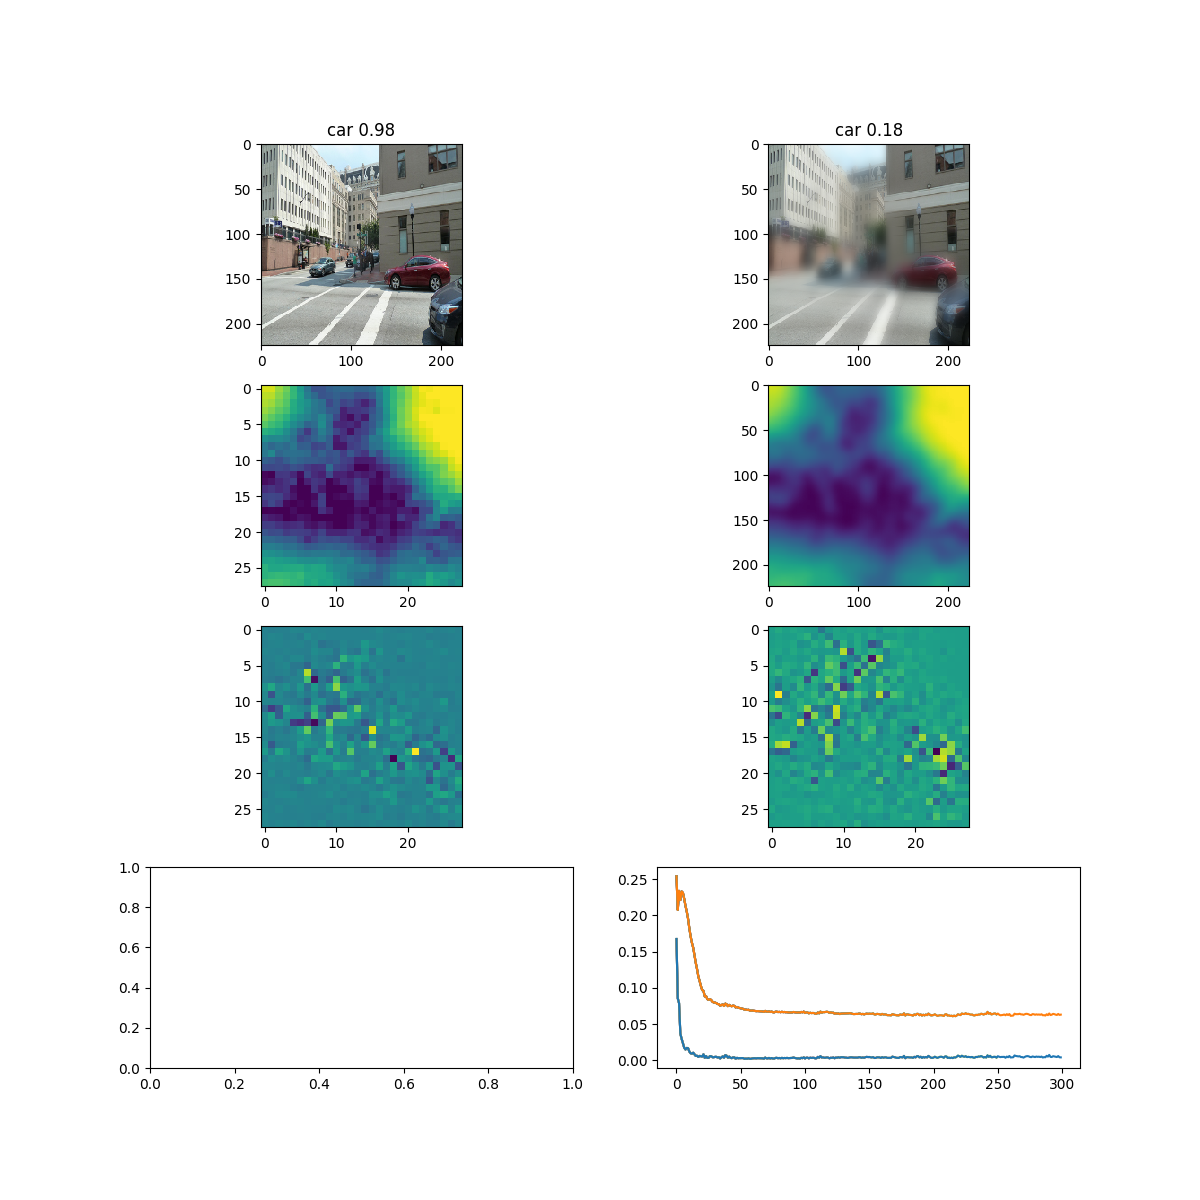

<IPython.core.display.Javascript object>


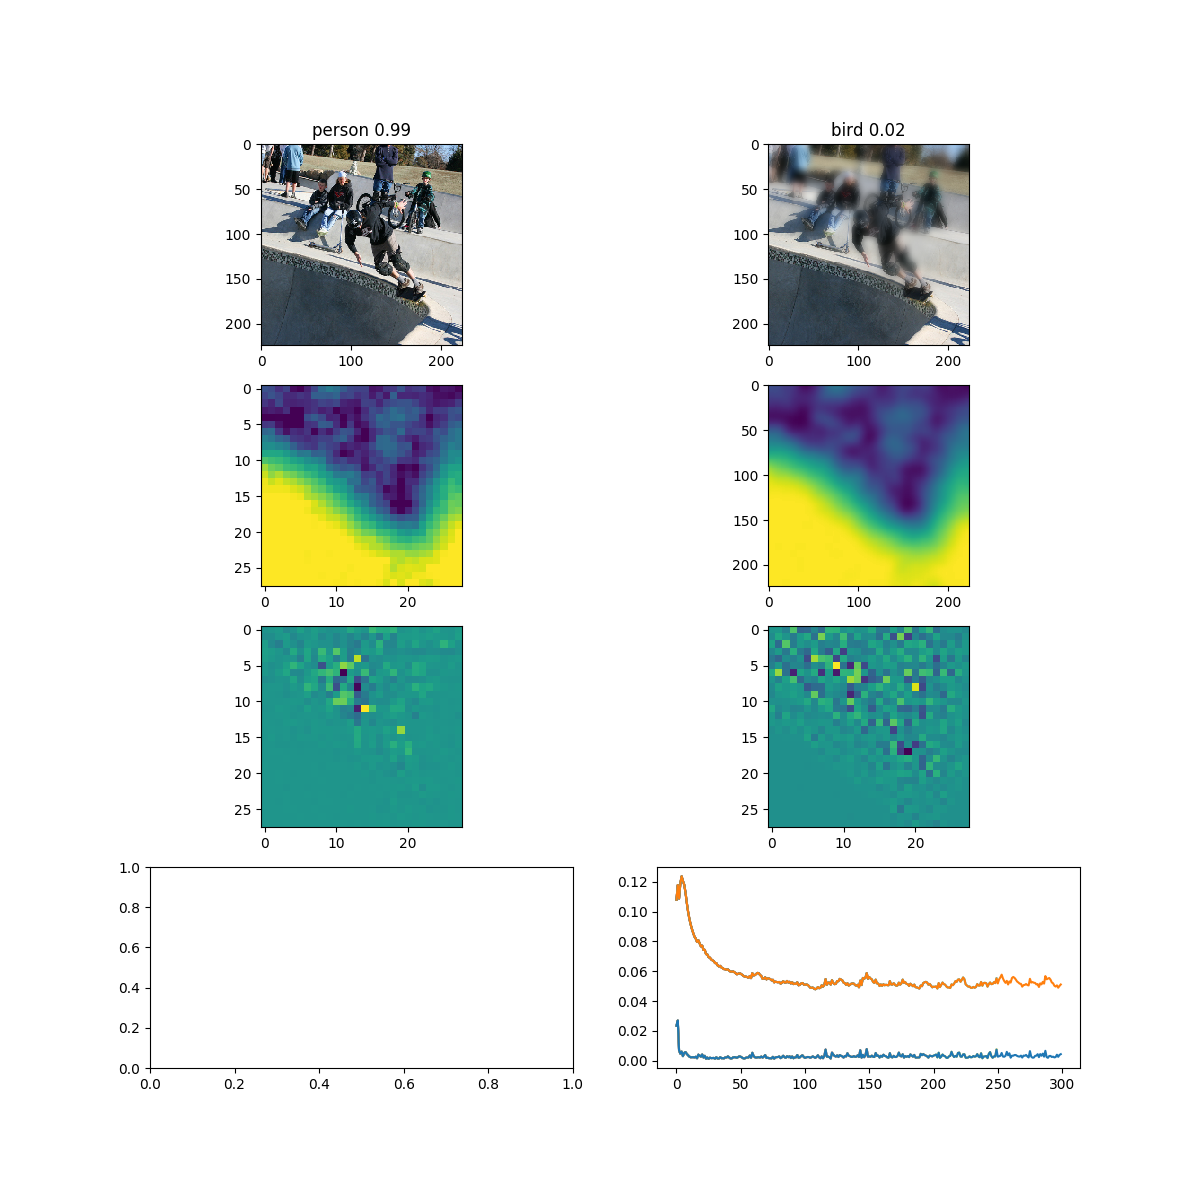

<IPython.core.display.Javascript object>


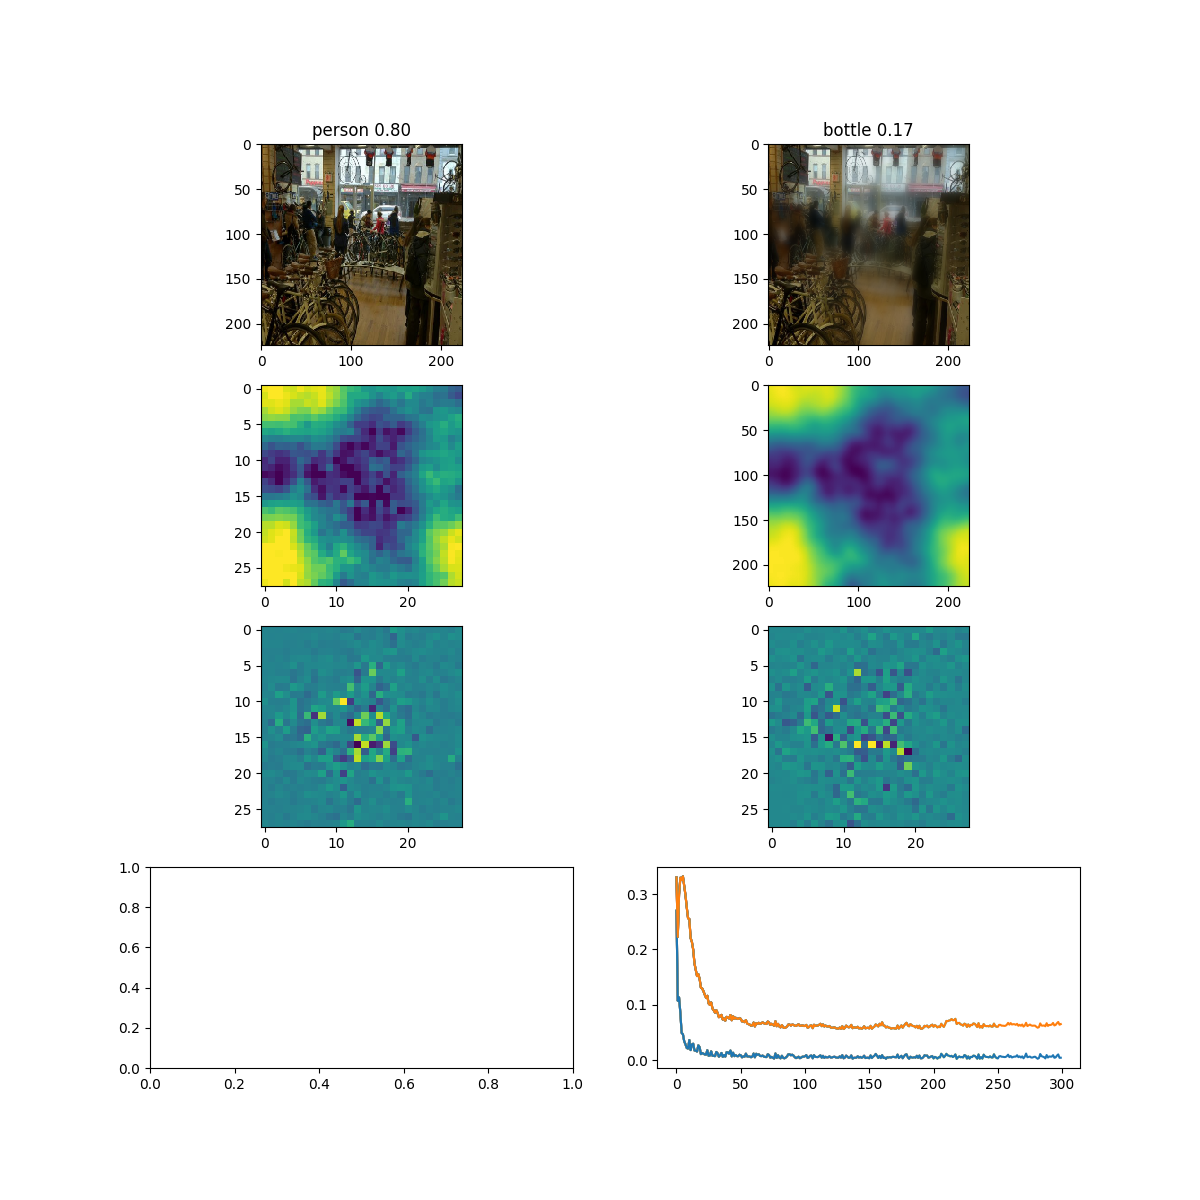

<IPython.core.display.Javascript object>


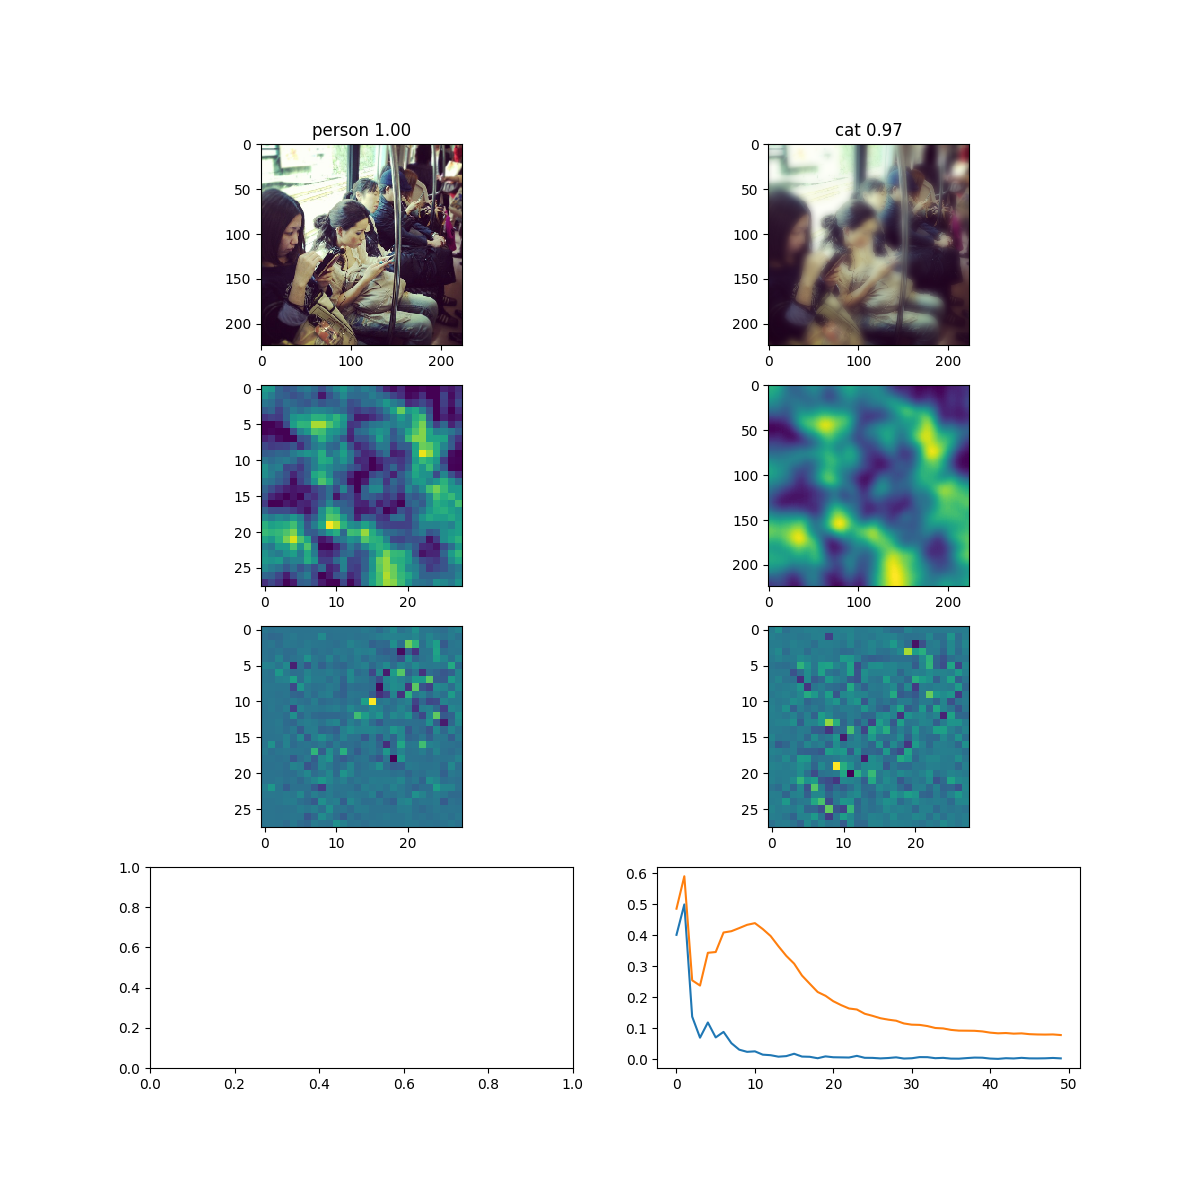

KeyboardInterrupt: 

In [37]:
# default parameters
num_iters = 300
lr = 1e-1
l1_lambda = 1e-4
l1_ideal = 1
l1_lambda_2 = 0
tv_lambda = 1e-2
tv_beta = 3
jitter = 4
num_top = 0
noise = 0
null_type = 'blur'
given_gradient = True
norm_score = False
end_layer = 'prob'
use_conv_norm = False
blur_mask = 5
mask_scale = 8

#mask_init = None
plot_step = 50
debug = False
verbose = False
mask_init_type = 'circle'

fig_dir = os.path.join('/data/ruthfong/neural_coding/pycaffe_figs/%s_%s_%s_given_grad_%d_norm_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_l1_lambda2_%.2f_tv_lambda_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2' % (
        net_type, dataset, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters))
mask_dir = os.path.join('/data/ruthfong/neural_coding/pycaffe_results/%s_%s_%s_given_grad_%d_norm_%d/min_top%d_prob_%s/lr_%.2f_l1_lambda_%.2f_tv_lambda_%.2f_l1_lambda_2_%.2f_beta_%.2f_mask_scale_%d_blur_mask_%d_jitter_%d_noise_%.1f_num_iters_%d_tv2' % (
        net_type, dataset, data_desc, int(given_gradient), int(norm_score), num_top, null_type, np.log10(lr), np.log10(l1_lambda), np.log10(l1_lambda_2), np.log10(tv_lambda), tv_beta, mask_scale, blur_mask, jitter, np.log10(noise), num_iters))    

for i in range(10):
    #net = get_net(net_type)
    net.blobs['data'].data.reshape(1,3,224,224)

    path = paths[i]
    label = labels[i]
    img = net_transformer.preprocess('data', caffe.io.load_image(path))
    net.blobs['data'].data[...] = img
    net.forward()
    scores = np.squeeze(net.blobs['prob'].data)
    sorted_idx = np.argsort(scores)
    if given_gradient:
        target = np.zeros(scores.shape)
        target[sorted_idx[:-(num_top+1):-1]] = 1
    else:
        target = sorted_idx[:-(num_top+1):-1]

    fig_path = None
    mask_path = None

    #fig_path = os.path.join(fig_dir, '%d_%d.png' % (int(path.strip('.jpg').split('_')[-1]), label))
    #mask_path = os.path.join(mask_dir, '%d_%d.npy' % (int(path.strip('.jpg').split('_')[-1]), label))

    #generate_learned_mask(net, net_transformer, path, label, fig_path = fig_path, mask_path = mask_path, gpu = gpu, show_fig = show_fig, 
    #            num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, 
    #            tv_lambda = tv_lambda, tv_beta = tv_beta, mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask,
    #            jitter = jitter, noise = noise, null_type = null_type, end_layer = end_layer, num_top = num_top, labels = labels_desc)
    generate_learned_mask(net, net_transformer, path, label, given_gradient = given_gradient, 
                          norm_score = norm_score, num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, 
                          l1_ideal = l1_ideal, l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, 
                          mask_scale = mask_scale, use_conv_norm = use_conv_norm, blur_mask = blur_mask, 
                          jitter = jitter, noise = noise, null_type = null_type, gpu = gpu, 
                          start_layer = 'data', end_layer = 'prob', plot_step = plot_step, debug = debug, 
                          fig_path = fig_path, mask_path = mask_path, verbose = verbose, show_fig = show_fig, 
                          mask_init_type = mask_init_type, num_top = num_top, labels = labels_desc)
    #mask = optimize_mask(net, path, target, labels = labels_desc, given_gradient = given_gradient, norm_score = norm_score,
    #                num_iters = num_iters, lr = lr, l1_lambda = l1_lambda, l1_ideal = l1_ideal,
    #                l1_lambda_2 = l1_lambda_2, tv_lambda = tv_lambda, tv_beta = tv_beta, mask_scale = mask_scale,
    #                use_conv_norm= use_conv_norm, blur_mask = blur_mask, jitter = jitter,
    #                null_type = null_type, mask_init = mask_init, gpu = gpu, start_layer = None, end_layer = end_layer,
    #                plot_step = plot_step, debug = debug, fig_path = fig_path, mask_path = mask_path, verbose = verbose)